In [2]:
from tqdm import tqdm
from jax.example_libraries.optimizers import adam
from jax import value_and_grad
from collections import namedtuple
import os
os.environ["CUDA_VISIBLE_DEVICES"] ='1'
import numpy as np
import matplotlib.pyplot as plt 
import jax
import jax.numpy as jnp
from jaxpm.growth import (dGf2a, dGfa, growth_factor, growth_factor_second,
                          growth_rate, growth_rate_second, dGfa, Gf)
from jax import tree
from jax import tree
from jaxpm.pm import pm_forces
from diffrax import ConstantStepSize,  SaveAt, diffeqsolve,StepTo
from jaxpm.plotting import plot_fields_single_projection
from jaxpm.painting import cic_paint , cic_paint_dx
import diffrax
#jax.config.update("jax_enable_x64", True)
import jax
jax.print_environment_info()
from SuperResPM.configure import Configuration
from SuperResPM.diffrax_helper import FPMODE,FPMLeapFrog,symplectic_ode
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('jpeg')
import jax_cosmo as jc
from diffrax import ConstantStepSize
from jaxpm.pm import linear_field, lpt
from jaxpm.growth import (dGf2a, dGfa, growth_factor, growth_factor_second,
                          growth_rate, growth_rate_second)
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader
%matplotlib inline 


jax:    0.5.2
jaxlib: 0.5.1
numpy:  2.1.3
python: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
device info: cpu-1, 1 local devices"
process_count: 1
platform: uname_result(system='Linux', node='nid001012', release='5.14.21-150500.55.97_13.0.78-cray_shasta_c', version='#1 SMP Thu Mar 13 20:09:44 UTC 2025 (330b47d)', machine='x86_64')


$ nvidia-smi
Tue Apr 22 19:53:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|===============================

/global/homes/c/chto100/.conda/envs/chtonew2/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
jc.__path__

['/global/homes/c/chto100/.conda/envs/chtonew2/lib/python3.10/site-packages/jax_cosmo']

In [4]:
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
jax.config.update("jax_enable_x64", True)

In [5]:

def full_field_model_pm_test(
    cube_size,
    cubegrid_size,
    a_init,
    a_center,
    adjoint
):
    @jax.jit
    def forward_model(cosmoin, lin_field):

        def paint_density(t, y, args):
            # Load positions and apply boundary conditions
            pos = y[0]
            x = pos[..., 1]
            y = pos[..., 2]
            z = pos[..., 0]

            # Paint all the particles that fall into slice
            ss=args[3].mesh_shape
            density = cic_paint(jnp.zeros(ss),jnp.c_[x, y, z])

            return density
            
        particles = jnp.stack(
            jnp.meshgrid(
                *[jnp.arange(s) for s in [cubegrid_size, cubegrid_size, cubegrid_size]]
            ),
            axis=-1)
        conf = Configuration(mesh_shape=[cubegrid_size, cubegrid_size, cubegrid_size],
                     snapshots= [1],
                     BoxSize=cube_size, 
                     initial_t0=a_init,
                     final_time = 1.0,
                     density_plane_npix = 10,
                     dt0=0.03)

        
        eps, p, f = lpt(cosmoin, lin_field, particles, a=conf.initial_t0)
        
        term = tree.map(
            FPMODE,
            symplectic_ode(conf.mesh_shape, paint_absolute_pos=True)
        )
        initforce = pm_forces(
            particles + eps,
            mesh_shape=conf.mesh_shape,
            paint_absolute_pos=True,
        )* 1.5* cosmoin.Omega_m  

        solver = FPMLeapFrog(initial_t0=conf.initial_t0, final_t1=conf.final_time)
        saveat = SaveAt(ts=a_center[::-1], fn=paint_density)
        stepsize_controller = ConstantStepSize()
        solution = diffeqsolve(
            term,
            solver,
            t0=conf.initial_t0,
            t1=conf.final_time,
            dt0=conf.dt0,
            y0=jnp.stack([particles + eps, p, initforce], axis=0),
            args=[cosmoin, None, conf.initial_t0, conf, 0, 0],\
            saveat=saveat,
            adjoint=adjoint,
            stepsize_controller=stepsize_controller,
        )
        
        args=[cosmoin, None, conf.initial_t0, conf, 0, 0]
        #density = paint_density(0, solution.ys[-1], args)
        ##print(solution.ys)
        #return density
        return solution.ys[-1]
    return forward_model
#####################################################################################################################


In [6]:

#if __name__ == "__main__":
key_number = 1
# Set output directory
dir_out = "./"
#Path(dir_out).mkdir(parents=True, exist_ok=True)
# Sim configuration
cube_size = 128.0  # Mpc/h
cubegrid_size = 32#128  # npix
a_init = 0.05
# Initialize the density model
dens_model_Recursive= full_field_model_pm_test(
    cube_size=cube_size,
    cubegrid_size=cubegrid_size,
    a_init = a_init,
    a_center=[0.96], 
    adjoint=diffrax.RecursiveCheckpointAdjoint()
)
dens_model_Reversible= full_field_model_pm_test(
    cube_size=cube_size,
    cubegrid_size=cubegrid_size,
    a_init = a_init,
    a_center=[0.96], 
    adjoint=diffrax.ReversibleAdjoint()#diffrax.RecursiveCheckpointAdjoint()#
)


In [7]:
def buildmodel(dens_model):
    @jax.jit
    def model(param):
        Omega_c, sigma8= param
        model_cosmo = jc.Cosmology(
            Omega_c=Omega_c,
            sigma8=sigma8,
            Omega_b=0.0492,
            Omega_k=0.0,
            h=0.67,
            n_s=0.96,
            w0=-1,
            wa=0.0,
        )
        Workspace = namedtuple('_workspace', ['background_radial_comoving_distance', 'background_growth_factor'])
        model_cosmo._workspace =Workspace(None, None)
        ain=np.atleast_1d(1)
        _ =  growth_rate_second(model_cosmo,ain)
        _ = growth_rate(model_cosmo, ain)
        _ = growth_factor(model_cosmo, ain)
        jc.background.radial_comoving_distance(model_cosmo, ain)
        k = jnp.logspace(-4, 1, 128)
        pk = jc.power.linear_matter_power(model_cosmo, k)
        pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)
        lin_field = linear_field(
            [cubegrid_size, cubegrid_size, cubegrid_size],
            [cube_size, cube_size, cube_size],
            pk_fn, jax.random.PRNGKey(0))
        dens = dens_model(model_cosmo, lin_field)
        return dens
    return model    


In [8]:
densobs = buildmodel(dens_model=dens_model_Recursive)(jnp.array([0.3,0.8]))


In [9]:
model_Reversible = buildmodel(dens_model=dens_model_Reversible)
model_Recursive = buildmodel(dens_model=dens_model_Recursive)

In [10]:
@jax.jit
def lnlikelihood_Reversible(param):
    din = model_Reversible(param)
    return jnp.sum(-0.5*(densobs-din)**2)
@jax.jit
def lnlikelihood_Recursive(param):
    din = model_Recursive(param)
    return jnp.sum(-0.5*(densobs-din)**2)

In [11]:
dL_Reversible = jax.jit(jax.value_and_grad(lnlikelihood_Reversible))
dL_Recursive = jax.jit(jax.value_and_grad(lnlikelihood_Recursive))

In [12]:
cosmology_omegam = np.random.normal(size=10)*0.02+0.2

In [13]:
cosmology_sigma8 = np.random.normal(size=10)*0.1+0.8300042969349488

In [14]:
omegam, sigma8=0.3,0.8

In [15]:
%prun dL_Reversible(jnp.array([omegam, sigma8]))#, model_Reversible)[1]

         25609419 function calls (25299231 primitive calls) in 29.612 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    9.052    9.052    9.066    9.066 compiler.py:297(backend_compile)
        1    4.066    4.066    4.066    4.066 pxla.py:1277(__call__)
        8    1.091    0.136    1.092    0.136 {built-in method gc.collect}
3793346/3793130    0.468    0.000    0.492    0.000 {built-in method builtins.isinstance}
    95666    0.342    0.000    1.387    0.000 named_sharding.py:500(preprocess)
   1001/1    0.331    0.000    3.884    3.884 mlir.py:1876(jaxpr_subcomp)
192220/192198    0.328    0.000    0.599    0.000 util.py:298(wrapper)
414475/406803    0.316    0.000    2.957    0.000 {jaxlib.utils.safe_map}
    32195    0.309    0.000    2.449    0.000 utils.py:84(standard_abstract_eval)
   143556    0.297    0.000    1.469    0.000 core.py:1821(get_sharding)
      394    0.215    0.001    0.217    0.001 api_ut

In [16]:
%prun dL_Recursive(jnp.array([omegam, sigma8]))#, model_Reversible)[1]

         30160255 function calls (29812128 primitive calls) in 29.645 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    8.763    8.763    8.777    8.777 compiler.py:297(backend_compile)
        1    4.010    4.010    4.010    4.010 pxla.py:1277(__call__)
        2    0.511    0.256    0.511    0.256 {built-in method gc.collect}
4412113/4411825    0.491    0.000    0.507    0.000 {built-in method builtins.isinstance}
    25772    0.468    0.000    0.804    0.000 lax.py:3445(naryop_dtype_rule)
    46859    0.441    0.000    0.472    0.000 partial_eval.py:1933(<listcomp>)
233407/233371    0.353    0.000    0.644    0.000 util.py:298(wrapper)
484675/462886    0.339    0.000    4.006    0.000 {jaxlib.utils.safe_map}
    69731    0.330    0.000    0.377    0.000 partial_eval.py:1808(<lambda>)
   174851    0.314    0.000    1.450    0.000 core.py:1821(get_sharding)
   1144/1    0.297    0.000    3.686    3.686 mlir.py:1

In [17]:
derivative=[]
for omegam, sigma8 in tqdm(zip(cosmology_omegam, cosmology_sigma8)):
    d1 = dL_Recursive(jnp.array([omegam, sigma8]))
    d2 = dL_Reversible(jnp.array([omegam, sigma8]))
    derivative.append([d1[1],d2[1]])
    print(d1,d2)

1it [00:08,  8.12s/it]

(Array(-32685.35642445, dtype=float64), Array([ 226507.7324992 , -254510.38338794], dtype=float64)) (Array(-32685.35642445, dtype=float64), Array([ 226507.7324992 , -254510.38338794], dtype=float64))


2it [00:16,  8.09s/it]

(Array(-3384.35331479, dtype=float64), Array([ 81858.84293365, -57119.33750389], dtype=float64)) (Array(-3384.35331479, dtype=float64), Array([ 81858.84293365, -57119.33750389], dtype=float64))


3it [00:24,  8.06s/it]

(Array(-2853.24743467, dtype=float64), Array([ 73458.74987341, -58993.5144386 ], dtype=float64)) (Array(-2853.24743467, dtype=float64), Array([ 73458.74987341, -58993.5144386 ], dtype=float64))


4it [00:32,  8.09s/it]

(Array(-5112.14536375, dtype=float64), Array([ 96495.25150166, -98466.16414565], dtype=float64)) (Array(-5112.14536375, dtype=float64), Array([ 96495.25150166, -98466.16414565], dtype=float64))


5it [00:40,  8.17s/it]

(Array(-4561.56885373, dtype=float64), Array([ -6058.59895852, 119712.42900021], dtype=float64)) (Array(-4561.56885373, dtype=float64), Array([ -6058.59895852, 119712.42900021], dtype=float64))


6it [00:48,  8.17s/it]

(Array(-8975.40044288, dtype=float64), Array([ 135159.92390827, -134498.23223276], dtype=float64)) (Array(-8975.40044288, dtype=float64), Array([ 135159.92390827, -134498.23223276], dtype=float64))


7it [00:56,  8.14s/it]

(Array(-11059.1625923, dtype=float64), Array([-32155.8072666 , 214748.32258518], dtype=float64)) (Array(-11059.1625923, dtype=float64), Array([-32155.8072666 , 214748.32258518], dtype=float64))


8it [01:05,  8.14s/it]

(Array(-35532.75601777, dtype=float64), Array([ 259117.43138734, -265576.79055438], dtype=float64)) (Array(-35532.75601777, dtype=float64), Array([ 259117.43138734, -265576.79055438], dtype=float64))


9it [01:13,  8.13s/it]

(Array(-31007.79331634, dtype=float64), Array([ 220197.10492182, -247599.78398195], dtype=float64)) (Array(-31007.79331634, dtype=float64), Array([ 220197.10492182, -247599.78398195], dtype=float64))


10it [01:21,  8.13s/it]

(Array(-2802.9339775, dtype=float64), Array([32694.41890874, 46741.3253623 ], dtype=float64)) (Array(-2802.9339775, dtype=float64), Array([32694.41890874, 46741.3253623 ], dtype=float64))


In [22]:
derivative = np.array(derivative)

In [23]:
derivative.shape

(10, 2, 2)

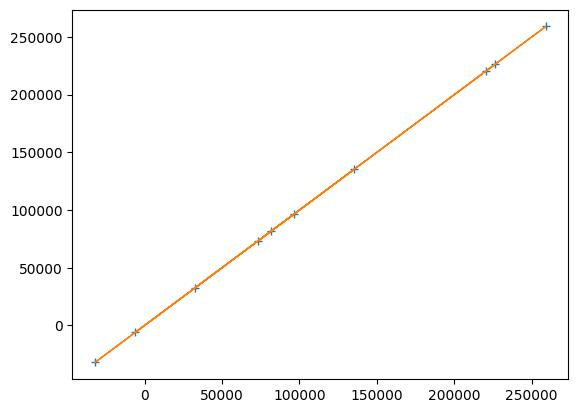

In [24]:
plt.plot(derivative[:,0,0],derivative[:,1,0], "+")
plt.plot(derivative[:,0,0],derivative[:,0,0], lw=1)




Text(0, 0.5, 'Derivative error (%)')

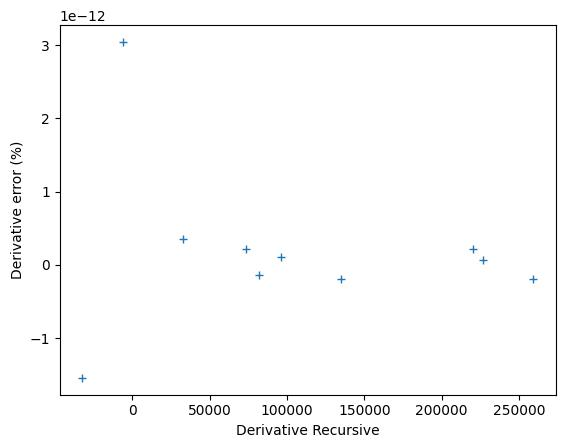

In [25]:
plt.plot(derivative[:,0,0], (derivative[:,1,0]/derivative[:,0,0]-1)*100, "+")
plt.xlabel("Derivative Recursive")
plt.ylabel("Derivative error (%)")




In [22]:
with jax.profiler.trace("tensorborard/"):
     dL_Reversible(jnp.array([omegam, sigma8]))#, model_Reversible)[1]

2025-04-21 11:11:40.442304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745251900.845194 2767057 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745251900.920901 2767057 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745251902.109694 2767057 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745251902.109737 2767057 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745251902.109739 2767057 computation_placer.cc:177] computation placer alr

In [23]:
with jax.profiler.trace("tensorborard/"):
     dL_Recursive(jnp.array([omegam, sigma8]))#, model_Reversible)[1]